In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import unicodedata
from collections import Counter
from pylab import rcParams
from wordcloud import WordCloud

from nltk import word_tokenize
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.stem import PorterStemmer, RSLPStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.stem.snowball import SnowballStemmer

rcParams['figure.figsize'] = 30, 60
%matplotlib inline

In [2]:
!pip install matplotlib

## Accessing the texts

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
project_dir = '/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles'

In [5]:
# gets files from article directory
fns = []
for file_name in os.listdir(project_dir):
    if file_name.endswith('.txt'):
        fns.append(os.path.join(project_dir,file_name))

In [6]:
# this opens the txt files and appends the text files to the text dataframe 
df_new = pd.DataFrame(columns=['fn', 'txt'])
for idx, fn in enumerate(fns):  
    print(fn)
    x = open(fn, mode="r", encoding="utf-8")
    x = x.read()  
    _df_new = pd.DataFrame([[idx, x]],columns=['fn', 'txt'])
    df_new = df_new.append(_df_new)
df_new = df_new.reset_index(drop=True) 

/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles/challenge2-article101.txt
/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles/challenge2-article117.txt
/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles/challenge2-article077.txt
/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles/challenge2-article100.txt
/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles/challenge2-article129.txt
/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles/challenge2-article114.txt
/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles/challenge2-article076.txt
/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles/challenge2-article089.txt
/content/drive/MyDrive/Estudos/Projetos/UnlockedZ/challenge-2/challenge2-articles/challenge2-article088.txt
/content/drive/MyDrive/Estud

In [7]:
df_new

,fn,txt
0,0,Ain't no mountain high enough for La Eterna's ...
1,1,I was hiking through the canyon and found this...
2,2,This is when the arthritis starts. A cheese t...
3,3,Are these la eterna bugs dangerous? Or just sc...
4,4,\n\n Foraging for foragers\n\n an article abo...
...,...,...
140,140,Is it legal to transport wild shrubs from La E...
141,141,La Eterna This flower was said to cure aging...
142,142,Join us in a cheese appreciation adventure!\n...
143,143,\n\n The strange things animals eat \n\n An a...


### Pre-processing

Some of the important steps in text preprocessing and normalization are:

converting words to lower/upper case
removing special characters
removing stopwords and high/low-frequency words
stemming/lemmatization
Let's proceed in order.

In [8]:
print("Text model:")
df_new['txt'].values[15]

Text model:


"  \tPolyploids, the Frankenstein of the conservation community This is a great article about the dangers of polyploids and how they can be set on purpose to bring out new and better characteristics of the plant. This flower is said to be able to heal all diseases, La Eterna. This is vital for some plant species as some mutations can really attack the plant as a whole as it speeds up its aging process and causes deformities and unnatural additions.  \tHow to make a hog one step closer to human Long list of animals and animals with closely related traits to humans and their field of studies and the article is on the science and how we can learn and adapt and apply this new and useful information and science to our own betterment.  \tWhy you can't have a pet wrasse If you have ever been that person that just wanted a pet, you will definitely want to read this if you have ever had a specific preference of an animal. This is a listicle of the many reasons why most pet stores just don't hav

Step 1 | Converting words to lower case

In [9]:
df_new['txtProcessed'] = df_new.txt.apply(lambda x: x.lower())
print("Text model:")
df_new['txtProcessed'].values[15]

Text model:


"  \tpolyploids, the frankenstein of the conservation community this is a great article about the dangers of polyploids and how they can be set on purpose to bring out new and better characteristics of the plant. this flower is said to be able to heal all diseases, la eterna. this is vital for some plant species as some mutations can really attack the plant as a whole as it speeds up its aging process and causes deformities and unnatural additions.  \thow to make a hog one step closer to human long list of animals and animals with closely related traits to humans and their field of studies and the article is on the science and how we can learn and adapt and apply this new and useful information and science to our own betterment.  \twhy you can't have a pet wrasse if you have ever been that person that just wanted a pet, you will definitely want to read this if you have ever had a specific preference of an animal. this is a listicle of the many reasons why most pet stores just don't hav

Step 2 | Removing special characters

I am going to remove all of the special characters; however, it pays to keep in mind that this is something to revisit depending on the results we get later. The following gives a list of all the special characters in our dataset:

In [10]:
# Selecting non alpha numeric charactes that are not spaces
special_chars = df_new.txt.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# Getting list of list into a single list
flat_list = [item for sublist in special_chars for item in sublist]

# Unique special characters
print("Estes são os caracteres especiais que temos:")
print(set(flat_list))

Estes são os caracteres especiais que temos:
{'”', ']', '#', '!', '[', ':', '\n', '"', ';', '%', '&', '$', '(', ')', '.', ',', '’', '\t', "'", '\x0b', '‘', '-', '?', '“', '…', '+', '/'}


In [11]:
# The next lines are for word in portuguese. Unicode normalize transforms a character into its Latin equivalent.
#import re
#import unicodedata

#def removespecialcharacters(palavra):
    #nfkd = unicodedata.normalize('NFKD', palavra)
    #palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    
    #return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento)

In [12]:
# Removing these special characters from the texts
import re
txt_backup = df_new.txtProcessed.copy()
df_new.txtProcessed = df_new.txtProcessed.apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
)

In [13]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
print("New text:")
df_new.txtProcessed.values[15]

New text:


'   polyploids  the frankenstein of the conservation community this is a great article about the dangers of polyploids and how they can be set on purpose to bring out new and better characteristics of the plant  this flower is said to be able to heal all diseases  la eterna  this is vital for some plant species as some mutations can really attack the plant as a whole as it speeds up its aging process and causes deformities and unnatural additions    how to make a hog one step closer to human long list of animals and animals with closely related traits to humans and their field of studies and the article is on the science and how we can learn and adapt and apply this new and useful information and science to our own betterment    why you can t have a pet wrasse if you have ever been that person that just wanted a pet  you will definitely want to read this if you have ever had a specific preference of an animal  this is a listicle of the many reasons why most pet stores just don t have t

In [15]:
token_lists = [word_tokenize(each) for each in df_new.txt]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in df_new.txtProcessed]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ", len(set(tokens)))

Number of unique tokens then:  4137
Number of unique tokens now:  3734


Step 3 | Removing stopwords and high/low-frequency words

In [16]:
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
noise_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
179


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
top_1_percentile[:10]

[('the', 1423),
 ('a', 843),
 ('to', 760),
 ('of', 732),
 ('is', 652),
 ('and', 621),
 ('in', 497),
 ('it', 434),
 ('that', 424),
 ('this', 286)]

In [18]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('respect', 1),
 ('elders', 1),
 ('approximately', 1),
 ('200', 1),
 ('double', 1),
 ('overpriced', 1),
 ('seafood', 1),
 ('fate', 1),
 ('freshwater', 1),
 ('pearl', 1)]

In [19]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])
print("Total de stopwords: " + str(len(noise_words)))

Total de stopwords: 253


In [20]:
# Modifying the list of stopwords words we want to keep or remove in the list
keep_analysisword = []
remove_analysisword = []

for word in list(keep_analysisword):
    if word in noise_words:
        noise_words.remove(word)
        
for word in list(remove_analysisword):
    if word not in noise_words:
        noise_words.append(word)
        
print("Queremos manter na análise as palavras: " + str(keep_analysisword))
print("Queremos remover da análise as palavras: " + str(remove_analysisword))
print("Total de stopwords: " + str(len(noise_words)))

noise_words.sort()
noise_words

Queremos manter na análise as palavras: []
Queremos remover da análise as palavras: []
Total de stopwords: 253


['200',
 '226',
 'a',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'aldabra',
 'all',
 'also',
 'am',
 'an',
 'and',
 'and',
 'any',
 'approximately',
 'arctic',
 'are',
 'are',
 'aren',
 "aren't",
 'as',
 'as',
 'at',
 'be',
 'be',
 'because',
 'been',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'bowhead',
 'but',
 'but',
 'by',
 'calm',
 'can',
 'can',
 'cheese',
 'conduct',
 'couldn',
 "couldn't",
 'crustaceans',
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'doing',
 'don',
 "don't",
 'double',
 'down',
 'during',
 'each',
 'elders',
 'eterna',
 'exhibited',
 'fate',
 'few',
 'floors',
 'for',
 'for',
 'freshwater',
 'from',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'has',
 'hasn',
 "hasn't",
 'have',
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'heavyweight',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'in',
 'into',
 'is',
 'is',
 'i

Step 4 | Stemming & lemmatization 

In [21]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [22]:
nltk.download('wordnet')

from nltk.corpus import wordnet

stemmer = nltk.stem.RSLPStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
#print("Understanding the difference between Stemmer and Lemmatizer:")
#print("For the words: trouble, troubling e troubled")
#print("\n")

#print("Lancaster Stemmer")
#print(stemmer.stem("trouble"))
#print(stemmer.stem("troubling"))
#print(stemmer.stem("troubled"))
#print("\n")

#print("WordNet Lemmatizer")
#print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
#print(lemmatizer.lemmatize("troubling", wordnet.VERB))
#print(lemmatizer.lemmatize("troubled", wordnet.VERB))

In [24]:
def get_word_tokens_col(series, stopwords):
    if stopwords == True:
        stopwords = noise_words
    else: 
        stopwords = []
    # Taking a single string
    text = ' '.join(series)

    # Separating the string into tokens
    word_tokens = nltk.word_tokenize(text)

    # Removendo as stopwords e lemmatizing
    # We can switch to stemmer when wanted
    word_tokens_clean = [lemmatizer.lemmatize(each) for each in word_tokens if each.lower() not in stopwords and len(each.lower()) > 2]

    return word_tokens_clean

In [25]:
def get_word_tokens_text(text, stopwords):
    if stopwords == True:
        stopwords = noise_words
    else: 
        stopwords = []
    # Separating the string into tokens
    word_tokens = nltk.word_tokenize(text)

    # Removendo as stopwords e lemmatizing
    # We can switch to stemmer when wanted
    word_tokens_clean = [lemmatizer.lemmatize(each) for each in word_tokens if each.lower() not in stopwords and len(each.lower()) > 2]

    return word_tokens_clean

In [26]:
def top_k_ngrams(series,n,k, mode,stopwords):
    # Transforming the strings into single-word n-word strings
    if mode == True:
        word_tokens = get_word_tokens_col(series,stopwords)
    else:
        word_tokens = get_word_tokens_text(series,stopwords)
    n_gram_list = list(ngrams(word_tokens, n))

    # Putting each n-gram into a string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    return list(most_common_k)

In [27]:
# Generating top words from all the texts
print(top_k_ngrams(df_new['txtProcessed'], 1, 10, True, True))

[('plant', 88), ('help', 82), ('used', 80), ('disease', 75), ('flower', 74), ('way', 72), ('people', 70), ('found', 61), ('good', 60), ('body', 60)]


In [28]:
# Plotting the most commom words
def plot_common_grams(df_new, qtd_palavras,top,stopwords):        
    common_words = top_k_ngrams(df_new.txtProcessed, qtd_palavras, top, True,stopwords)
    for word, freq in common_words:
        print(word, freq)
    df = pd.DataFrame(common_words, columns = ['CommonWords' , 'count'])
    rcParams['figure.figsize'] = 15, 5
    df.groupby('CommonWords').sum()['count'].sort_values(ascending=False).plot(
       kind='bar',  title='Top n-grams')
    print(df)

plant 88
help 82
used 80
disease 75
flower 74
way 72
people 70
found 61
good 60
body 60
  CommonWords  count
0       plant     88
1        help     82
2        used     80
3     disease     75
4      flower     74
5         way     72
6      people     70
7       found     61
8        good     60
9        body     60


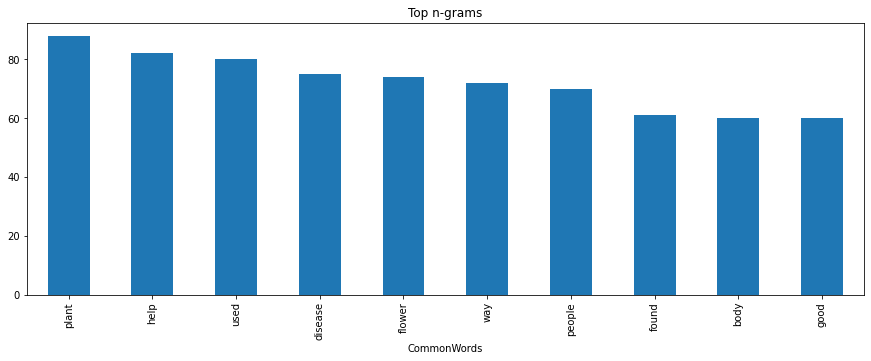

In [29]:
plot_common_grams(df_new,1,10, True)

In [30]:
# Generating top words from each text
txt_list = df_new.fn.unique()

for fn in txt_list:
    df_pos = df_new[(df_new.fn == fn)]
    print('In text ' + str(fn) + ' we have these 3 groups of words that appear frequently:' )
    print(top_k_ngrams(df_pos['txtProcessed'], 1, 3, True, True))
    print('\n')

In text 0 we have these 3 groups of words that appear frequently:
[('mountain', 1), ('high', 1), ('enough', 1)]


In text 1 we have these 3 groups of words that appear frequently:
[('hiking', 1), ('canyon', 1), ('found', 1)]


In text 2 we have these 3 groups of words that appear frequently:
[('smell', 3), ('great', 2), ('like', 2)]


In text 3 we have these 3 groups of words that appear frequently:
[('bug', 1), ('dangerous', 1), ('scary', 1)]


In text 4 we have these 3 groups of words that appear frequently:
[('get', 5), ('wild', 5), ('plant', 5)]


In text 5 we have these 3 groups of words that appear frequently:
[('migraine', 1), ('anyone', 1), ('heard', 1)]


In text 6 we have these 3 groups of words that appear frequently:
[('butter', 9), ('benefit', 4), ('food', 4)]


In text 7 we have these 3 groups of words that appear frequently:
[('leaf', 1), ('shrub', 1), ('remind', 1)]


In text 8 we have these 3 groups of words that appear frequently:
[('better', 1), ('way', 1), ('spend',

In [31]:
def word_cloud(serie,n,k, stopwords):
    ## Principais n-grams
    top_ngrams = top_k_ngrams(df_new.txtProcessed,n,k,True, stopwords)
    
    
    # Criando o wordcloud
    wordcloud = WordCloud(max_font_size=100, max_words=400, background_color="white",\
                          scale = 10,width=800, height=400, collocations = True).generate_from_frequencies(dict(top_ngrams))

    rcParams['figure.figsize'] = 20, 40
    # Plot
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

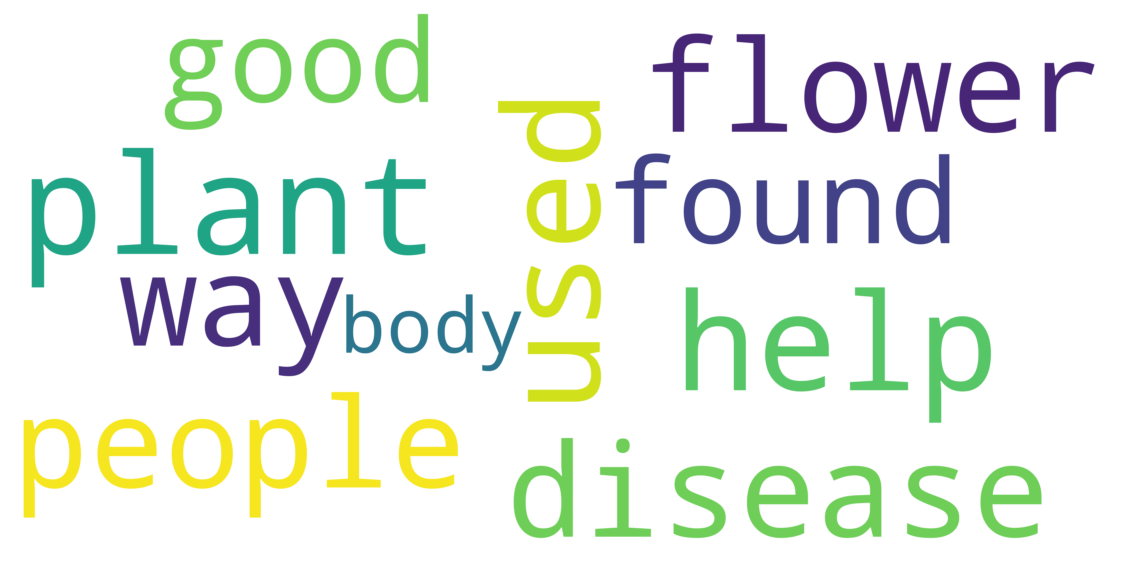

In [43]:
word_cloud(df_pos, 1, 10, True)

## Topic modeling exploration with pyLDAvis

Based on: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [33]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import spacy

import pickle
import re 

import matplotlib.pyplot as plt 
import pandas as pd

In [34]:
# Generating top words from each text
txt_list = df_new.fn.unique()

for fn in txt_list:
    df_pos = df_new[(df_new.fn == fn)]
    #print('In text ' + str(fn) + ' we have these 3 groups of words that appear frequently:' )
    print(get_word_tokens_col(df_pos['txtProcessed'], True))
    print('\n')

['mountain', 'high', 'enough', 'shrub', 'reach', 'even', 'top', 'still', 'grow', 'harshest', 'condition']


['hiking', 'canyon', 'found', 'evil', 'looking', 'bug', 'jumped', 'screamed']


['arthritis', 'start', 'bring', 'headache', 'joint', 'pain', 'fatigue', 'much', 'overwhelming', 'marjorro', 'sure', 'wonderful', 'bad', 'great', 'board', 'likely', 'feel', 'like', 'need', 'use', 'hand', 'mixer', 'get', 'either', 'way', 'definitely', 'long', 'life', 'business', 'probably', 'good', 'way', 'noise', 'smell', 'vision', 'get', 'greeting', 'africa', 'whether', 'looking', 'fun', 'food', 'simply', 'curious', 'type', 'surely', 'intriguing', 'like', 'made', 'substance', 'land', 'animal', 'utilize', 'live', 'namely', 'grass', 'natural', 'substance', 'called', 'strong', 'smell', 'strong', 'color', 'bright', 'green', 'lovely', 'leafy', 'smell', 'great', 'glass', 'wine', 'salty', 'water', 'big', 'fan', 'salty', 'crunchy', 'snack', 'leave', 'thirstier', 'able', 'glass', 'water', 'sound', 'right', 'be

In [35]:
txt_list = df_new.fn.unique()
corpus = []

for fn in txt_list:
    df_pos = df_new[(df_new.fn == fn)]
    data = get_word_tokens_col(df_pos['txtProcessed'], True)

    corpus.append(get_word_tokens_col(data, True))
print(corpus)
 #   print('\n')

[['mountain', 'high', 'enough', 'shrub', 'reach', 'even', 'top', 'still', 'grow', 'harshest', 'condition'], ['hiking', 'canyon', 'found', 'evil', 'looking', 'bug', 'jumped', 'screamed'], ['arthritis', 'start', 'bring', 'headache', 'joint', 'pain', 'fatigue', 'much', 'overwhelming', 'marjorro', 'sure', 'wonderful', 'bad', 'great', 'board', 'likely', 'feel', 'like', 'need', 'use', 'hand', 'mixer', 'get', 'either', 'way', 'definitely', 'long', 'life', 'business', 'probably', 'good', 'way', 'noise', 'smell', 'vision', 'get', 'greeting', 'africa', 'whether', 'looking', 'fun', 'food', 'simply', 'curious', 'type', 'surely', 'intriguing', 'like', 'made', 'substance', 'land', 'animal', 'utilize', 'live', 'namely', 'grass', 'natural', 'substance', 'called', 'strong', 'smell', 'strong', 'color', 'bright', 'green', 'lovely', 'leafy', 'smell', 'great', 'glass', 'wine', 'salty', 'water', 'big', 'fan', 'salty', 'crunchy', 'snack', 'leave', 'thirstier', 'able', 'glass', 'water', 'sound', 'right', 'bes

In [36]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [37]:
pip install -U gensim 

In [38]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.014*"disease" + 0.009*"responsible" + 0.008*"brain" + 0.008*"cure" + 0.008*"area" + 0.008*"kingdom" + 0.007*"neurological" + 0.007*"hormone" + 0.007*"regulation" + 0.007*"aeren"'),
 (1,
  '0.034*"help" + 0.015*"neurological" + 0.014*"disorder" + 0.013*"found" + 0.013*"film" + 0.013*"prevent" + 0.012*"reverse" + 0.012*"way" + 0.011*"human" + 0.010*"tribe"'),
 (2,
  '0.017*"stage" + 0.016*"body" + 0.009*"medicine" + 0.008*"called" + 0.008*"repair" + 0.008*"decline" + 0.007*"first" + 0.007*"fact" + 0.006*"civilization" + 0.006*"flower"'),
 (3,
  '0.014*"used" + 0.010*"mountain" + 0.008*"milk" + 0.006*"herb" + 0.006*"story" + 0.005*"plant" + 0.005*"symptom" + 0.005*"include" + 0.005*"ancient" + 0.005*"people"'),
 (4,
  '0.009*"good" + 0.008*"brain" + 0.007*"food" + 0.007*"way" + 0.007*"body" + 0.006*"protein" + 0.006*"story" + 0.005*"help" + 0.005*"world" + 0.005*"disease"'),
 (5,
  '0.009*"plant" + 0.008*"milk" + 0.007*"flower" + 0.007*"ancient" + 0.007*"good" + 0.007*"people" +

In [42]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.108775  0.000410       1        1  20.900487
4     -0.016460 -0.081605       2        1  17.992506
6      0.056457  0.029899       3        1  16.647025
3      0.058903 -0.002455       4        1  13.220707
7      0.043813 -0.103519       5        1   8.773984
2     -0.022133  0.140549       6        1   7.919916
0     -0.055932  0.064812       7        1   7.550017
1     -0.173424 -0.048091       8        1   6.995358, topic_info=              Term       Freq      Total Category  logprob  loglift
281           help  60.000000  60.000000  Default  30.0000  30.0000
927   neurological  28.000000  28.000000  Default  29.0000  29.0000
378          stage  20.000000  20.000000  Default  28.0000  28.0000
251           body  46.000000  46.000000  Default  27.0000  27.0000
126        disease  59.000000  59.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
229           used   7.294310  63.312926   Topic8  -4.7261   0.4989
1258     treatment   3.572218  22.281689   Topic8  -5.4400   0.8293
700           keep   3.463435   9.556017   Topic8  -5.4710   1.6450
908          brain   3.444426  35.945613   Topic8  -5.4765   0.3147
322        vitamin   3.438817   8.304077   Topic8  -5.4781   1.7783

[526 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2766      7  0.466784     1900s
903       6  0.206893      acid
903       8  0.620680      acid
1778      4  0.642680  activity
1778      6  0.214227  activity
...     ...       ...       ...
1353      1  0.718332       yet
1353      4  0.119722       yet
1353      5  0.119722       yet
575       3  0.816167       zoo
2465      4  0.897857  zucchini

[1111 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 7, 4, 8, 3, 1, 2])